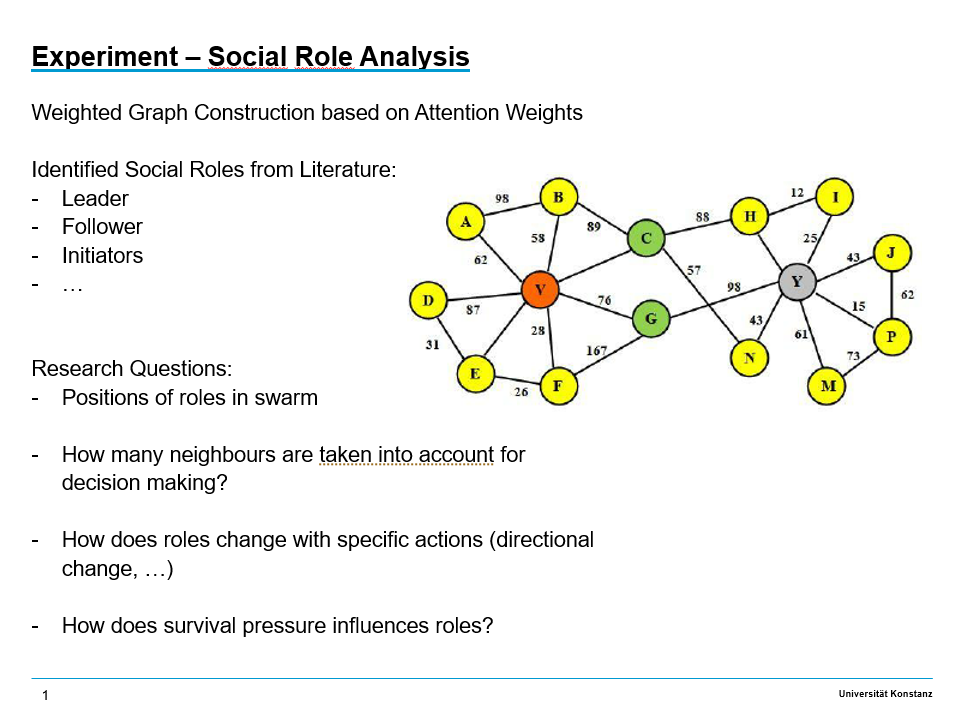

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import cv2
import glob
import torch
import pickle
import keyboard
import datetime
import numpy as np
from PIL import Image
import custom_marl_aquarium
from utils.es_utils import *
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from models.Buffer import Buffer, Pool
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [21]:
'''
Unterteilung in Leader, Follower, Initiators (und auch Recruiters welche andere animieren)
- Leadership sei teilweise asymmetrisch
- Geschwindigkeits-induzierte Führung (https://doi.org/10.1016/j.cub.2017.08.004)
- Verhaltenskaskaden beim Informationsfluss (https://doi.org/10.1038/s41598-022-14337-0)
'''

'\nUnterteilung in Leader, Follower, Initiators (und auch Recruiters welche andere animieren)\n- Leadership sei teilweise asymmetrisch\n- Geschwindigkeits-induzierte Führung (https://doi.org/10.1016/j.cub.2017.08.004)\n- Verhaltenskaskaden beim Informationsfluss (https://doi.org/10.1038/s41598-022-14337-0)\n'

In [22]:
# GAIL Model Path
gail_folder = "GAIL Training - 19.11.2025_18.52 - Couzin Data"
model_folder = rf"..\data\2. Training\training"
gail_path = os.path.join(model_folder, "GAIL", gail_folder)

# Startframe pool
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Paths
pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
prey_img_path = rf"..\data\3. Evaluation\images\prey.png"
attn_graph_dir = rf"..\results\experiment garcia\attention graph frames"

In [23]:
start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
print("Environment initialized")

Start frames in pool: 11978
Environment initialized


In [24]:
num_steps = 500

# GAIL Simulation
gail_pred_policy = torch.load(os.path.join(gail_path, "gail_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(gail_path, "gail_prey_policy.pt"), weights_only=False)
gail_metrics = run_policies_in_steps(env, gail_pred_policy, gail_prey_policy, steps=num_steps, render=False)
print("GAIL Simulation done!")

GAIL Simulation done!


In [25]:
def compute_incoming_weights(frame_metrics):
    weights_pred, weights_prey = frame_metrics["weights"]
    idx_info = frame_metrics["weights_idx"]

    pred_self = idx_info["pred"]["self"]
    pred_neighbors = np.array(idx_info["pred"]["neighbors"])
    prey_self = np.array(idx_info["prey"]["self"])
    prey_neighbors = np.array(idx_info["prey"]["neighbors"])

    incoming = np.zeros(33, dtype=float)

    for j, tgt in enumerate(pred_neighbors):
        incoming[tgt] += float(weights_pred[0, j])

    for r, focal in enumerate(prey_self):
        for c, tgt in enumerate(prey_neighbors[r]):
            incoming[tgt] += float(weights_prey[r, c])

    prey_incoming = incoming[1:]
    incoming_min = prey_incoming.min()
    incoming_max = prey_incoming.max()
    incoming_scaled = 0.2 + (prey_incoming - incoming_min) / (incoming_max - incoming_min) * (1.0 - 0.2) # Scale to alpha range for transparency
    incoming = np.insert(incoming_scaled, 0, incoming[0])

    incoming_dict = {f"predator_{pred_self}": 0.999} #{f"predator_{pred_self}": incoming[pred_self]}
    for i in prey_self:
        incoming_dict[f"prey_{i}"] = incoming[i]

    return incoming_dict

incoming_dict = compute_incoming_weights(gail_metrics[9])

In [ ]:
def draw_attention_graph(metrics, frame_idx=1, pred_img_path=None, prey_img_path=None):
    
    states = metrics[frame_idx]["global_state"]
    sorted_gs = dict(sorted(states.items())) # predator first
    arrays = list(sorted_gs.values())

    xs = np.array([a[1] for a in arrays], dtype=np.float32)  # [0, 1]
    ys = np.array([a[2] for a in arrays], dtype=np.float32)  # [0, 1]
    directions = np.array([a[3] for a in arrays], dtype=np.float32)  # [0, 1]

    # center the graph
    x_center = xs.mean()
    y_center = ys.mean()
    xs_centered = xs - x_center
    ys_centered = ys - y_center

    max_range = max(max(xs_centered), max(ys_centered), abs(min(xs_centered)), abs(min(ys_centered))) + 0.05 # automated scaling + margin

    n_agents = len(xs_centered)

    fig, ax = plt.subplots(figsize=(7, 7))

    # Draw edges
    for i in range(n_agents):
        for j in range(i+1, n_agents):
            ax.plot([xs_centered[i], xs_centered[j]],
                    [ys_centered[i], ys_centered[j]],
                    color="gray", linewidth=1, alpha=0.2)

    # Nodes as Images
    pred_image = Image.open(pred_img_path).convert("RGBA")
    prey_image = Image.open(prey_img_path).convert("RGBA")

    alphas = compute_incoming_weights(metrics[frame_idx])  # to get incoming weights for transparency

    for i in range(n_agents):
        angle_rad = directions[i] * 2 * np.pi # Heading [0,1] to (0–360°)
        angle_deg = np.degrees(angle_rad)

        base_img = pred_image if i == 0 else prey_image

        alpha = alphas[f"predator_0"] if i == 0 else alphas[f"prey_{i}"]

        rotated_img = base_img.rotate(-angle_deg, resample=Image.BICUBIC, expand=True)
        rotated_img = np.asarray(rotated_img).copy()

        # Mark leader prey red
        if alpha == 1.0:
            rotated_img = rotated_img.astype(float)
            rotated_img[..., 0] *= 1.8
            rotated_img[..., 1] *= 0.6
            rotated_img[..., 2] *= 0.6
            rotated_img = np.clip(rotated_img, 0, 255).astype(np.uint8)

        rotated_img[:, :, 3] = (rotated_img[:, :, 3].astype(float) * alpha).astype(np.uint8)

        imgbox = OffsetImage(rotated_img, zoom=0.45)
        imgbox.rotation = angle_deg
        ann_box = AnnotationBbox(imgbox, (xs_centered[i], ys_centered[i]), frameon=False, xycoords='data', zorder=2)
        ax.add_artist(ann_box)

    ax.set_title(f"Attention Graph (Frame {frame_idx})")
    ax.set_facecolor("#ACCEE7") # blue from marl_aquarium
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    plt.tight_layout()
    plt.show()

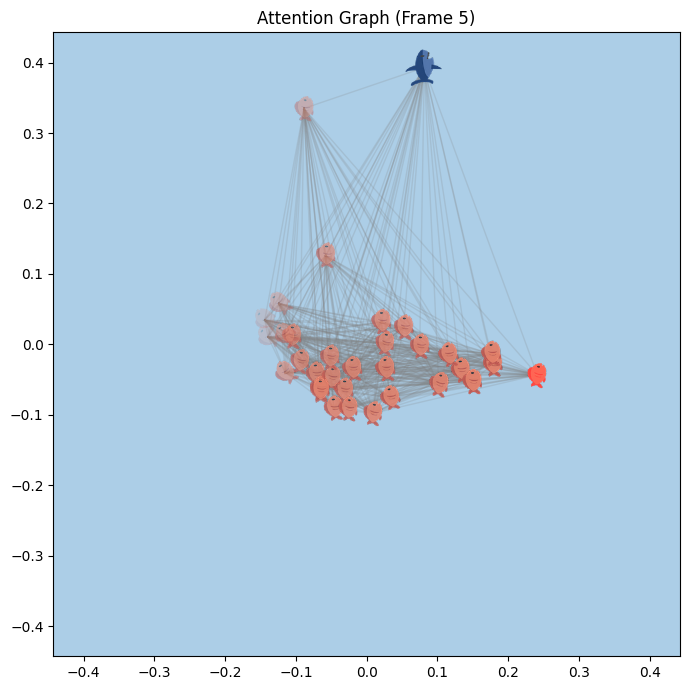

In [27]:
draw_attention_graph(gail_metrics, frame_idx=5, pred_img_path=pred_img_path, prey_img_path=prey_img_path)

In [74]:
def draw_predator_attention_graph(metrics, frame_idx=1, pred_img_path=None, prey_img_path=None):
    
    states = metrics[frame_idx]["global_state"]
    sorted_gs = dict(sorted(states.items())) # predator first
    arrays = list(sorted_gs.values())

    xs = np.array([a[1] for a in arrays], dtype=np.float32)  # [0, 1]
    ys = np.array([a[2] for a in arrays], dtype=np.float32)  # [0, 1]
    directions = np.array([a[3] for a in arrays], dtype=np.float32)  # [0, 1]

    # center the graph
    x_center = xs.mean()
    y_center = ys.mean()
    xs_centered = xs - x_center
    ys_centered = ys - y_center

    max_range = max(max(xs_centered), max(ys_centered), abs(min(xs_centered)), abs(min(ys_centered))) + 0.05 # automated scaling + margin

    n_agents = len(xs_centered)

    fig, ax = plt.subplots(figsize=(7, 7))

    # Draw edges
    for i in range(1): # only predator's edges
        for j in range(i+1, n_agents):
            ax.plot([xs_centered[i], xs_centered[j]],
                    [ys_centered[i], ys_centered[j]],
                    color="gray", linewidth=1, alpha=0.2)

    # Nodes as Images
    pred_image = Image.open(pred_img_path).convert("RGBA")
    prey_image = Image.open(prey_img_path).convert("RGBA")

    pred_weights = metrics[2]["weights"][0][0]

    weight_min = pred_weights.min()
    weight_max = pred_weights.max()
    weights_scaled = 0.2 + (pred_weights - weight_min) / (weight_max - weight_min) * (1.0 - 0.2) # Scale to alpha range for transparency

    weights_arr = weights_scaled.detach().cpu().numpy()

    for i in range(n_agents):
        angle_rad = directions[i] * 2 * np.pi # Heading [0,1] to (0–360°)
        angle_deg = np.degrees(angle_rad)

        base_img = pred_image if i == 0 else prey_image

        alpha = 0.999 if i == 0 else weights_arr[i-1]

        rotated_img = base_img.rotate(-angle_deg, resample=Image.BICUBIC, expand=True)
        rotated_img = np.asarray(rotated_img).copy()

        if alpha == 1.0:
                rotated_img = rotated_img.astype(float)
                rotated_img[..., 0] *= 0.6
                rotated_img[..., 1] *= 0.6
                rotated_img[..., 2] *= 1.6
                rotated_img = np.clip(rotated_img, 0, 255).astype(np.uint8)

        rotated_img[:, :, 3] = (rotated_img[:, :, 3].astype(float) * alpha).astype(np.uint8)

        imgbox = OffsetImage(rotated_img, zoom=0.45)
        imgbox.rotation = angle_deg
        ann_box = AnnotationBbox(imgbox, (xs_centered[i], ys_centered[i]), frameon=False, xycoords='data', zorder=2)
        ax.add_artist(ann_box)

    ax.set_title(f"Predator Attention Graph (Frame {frame_idx})")
    ax.set_facecolor("#ACCEE7") # blue from marl_aquarium
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    plt.tight_layout()
    plt.show()

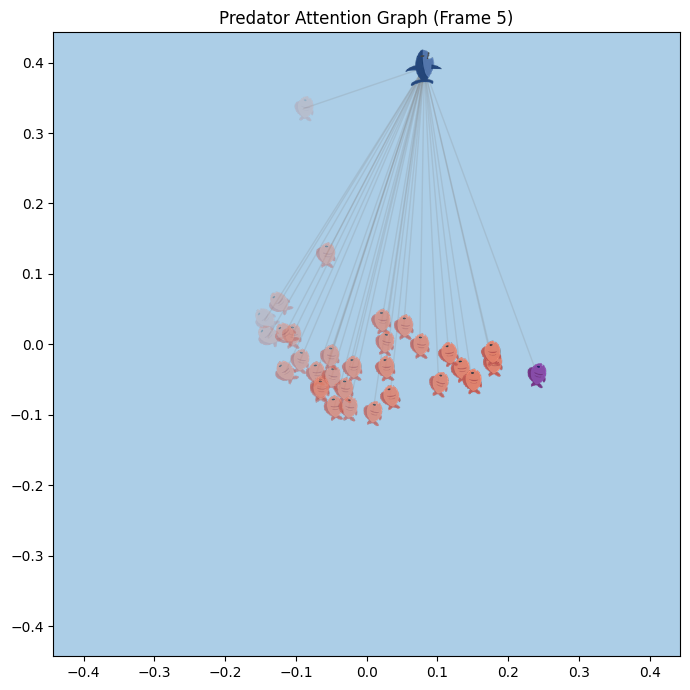

In [75]:
draw_predator_attention_graph(gail_metrics, frame_idx=5, pred_img_path=pred_img_path, prey_img_path=prey_img_path)

In [ ]:
def make_video(frames_dir):
    files = sorted(os.listdir(frames_dir), reverse=True)
    first = cv2.imread(os.path.join(frames_dir, files[0]))
    h, w, _ = first.shape

    video = cv2.VideoWriter(os.path.join(frames_dir, "video.mp4"), cv2.VideoWriter_fourcc(*"mp4v"), 10, (w, h))

    for f in files:
        frame = cv2.imread(os.path.join(frames_dir, f))
        video.write(frame)

    video.release()


def record_attn_graph_video(metrics, num_steps=50, pred_img_path=None, prey_img_path=None, save_dir=None):
    timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
    folder_name = f"Experiment Garcia - {timestamp}"
    folder_path = os.path.join(save_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    for frame_idx in range(num_steps):
        states = metrics[frame_idx]["global_state"]
        sorted_gs = dict(sorted(states.items())) # predator first
        arrays = list(sorted_gs.values())

        xs = np.array([a[1] for a in arrays], dtype=np.float32)  # [0, 1]
        ys = np.array([a[2] for a in arrays], dtype=np.float32)  # [0, 1]
        directions = np.array([a[3] for a in arrays], dtype=np.float32)  # [0, 1]

        n_agents = len(xs)

        fig, ax = plt.subplots(figsize=(7, 7))

        # Draw edges
        for i in range(n_agents):
            for j in range(i+1, n_agents):
                ax.plot([xs[i], xs[j]],
                        [ys[i], ys[j]],
                        color="gray", linewidth=1, alpha=0.2)

        # Nodes as Images
        pred_image = Image.open(pred_img_path).convert("RGBA")
        prey_image = Image.open(prey_img_path).convert("RGBA")

        alphas = compute_incoming_weights(metrics[frame_idx])  # to get incoming weights for transparency

        for i in range(n_agents):
            angle_rad = directions[i] * 2 * np.pi # Heading [0,1] to (0–360°)
            angle_deg = np.degrees(angle_rad)

            base_img = pred_image if i == 0 else prey_image

            alpha = alphas[f"predator_0"] if i == 0 else alphas[f"prey_{i}"]

            rotated_img = base_img.rotate(-angle_deg, resample=Image.BICUBIC, expand=True)
            rotated_img = np.asarray(rotated_img).copy()

            # Mark leader prey red
            if alpha == 1.0:
                rotated_img = rotated_img.astype(float)
                rotated_img[..., 0] *= 1.8
                rotated_img[..., 1] *= 0.6
                rotated_img[..., 2] *= 0.6
                rotated_img = np.clip(rotated_img, 0, 255).astype(np.uint8)

            rotated_img[:, :, 3] = (rotated_img[:, :, 3].astype(float) * alpha).astype(np.uint8)

            imgbox = OffsetImage(rotated_img, zoom=0.45)
            imgbox.rotation = angle_deg
            ann_box = AnnotationBbox(imgbox, (xs[i], ys[i]), frameon=False, xycoords='data', zorder=2)
            ax.add_artist(ann_box)

        ax.set_title(f"Attention Graph")
        ax.set_facecolor("#ACCEE7") # blue from marl_aquarium
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        plt.tight_layout()

        output_path = os.path.join(folder_path, f"attention_graph_{frame_idx:03d}.png")
        fig.savefig(output_path, dpi="figure")
        plt.close(fig)

        if frame_idx % 25 == 0:
            print(f"Saved frame {frame_idx}/{num_steps}")

    print("Video rendered!")

    make_video(folder_path)

In [29]:
record_attn_graph_video(gail_metrics, num_steps=num_steps, pred_img_path=pred_img_path, prey_img_path=prey_img_path, save_dir=attn_graph_dir)

Saved frame 0/500
Saved frame 25/500
Saved frame 50/500
Saved frame 75/500
Saved frame 100/500
Saved frame 125/500
Saved frame 150/500
Saved frame 175/500
Saved frame 200/500
Saved frame 225/500
Saved frame 250/500
Saved frame 275/500
Saved frame 300/500
Saved frame 325/500
Saved frame 350/500
Saved frame 375/500
Saved frame 400/500
Saved frame 425/500
Saved frame 450/500
Saved frame 475/500
Video rendered!
